## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

### 1. Import Library

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
mypath='/content/drive/MyDrive/Cats_and_Dogs'
print(os.listdir(mypath))
#print(os.listdir("../input"))

['train_small', 'test1_small']


### 2. Define Constants

In [6]:
FAST_RUN = True #False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### 3. Prepare Traning Data

In [8]:
filenames = os.listdir("/content/drive/MyDrive/Cats_and_Dogs/train_small")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.head()

filename  category
0  dog.3206.jpg         1
1  cat.5530.jpg         0
2  dog.8076.jpg         1
3  cat.4572.jpg         0
4  cat.8627.jpg         0

In [10]:
df.tail()

filename  category
2496  cat.5519.jpg         0
2497  dog.6991.jpg         1
2498  cat.4735.jpg         0
2499  cat.1312.jpg         0
2500  dog.1173.jpg         1

#### See Total In count

<Axes: >

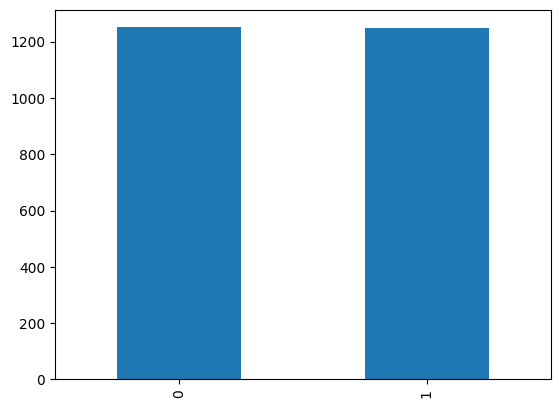

In [11]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

#### See sample image

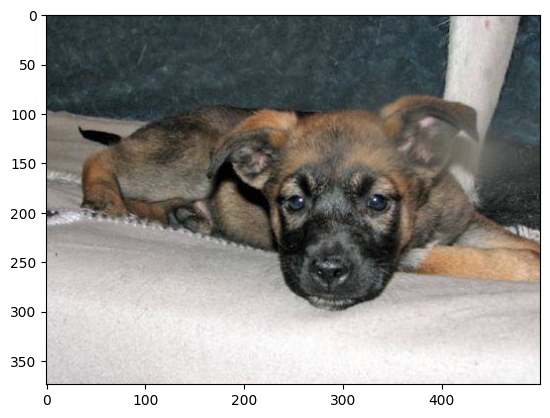

In [12]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Cats_and_Dogs/train_small/"+sample)
plt.imshow(image)

### 4. Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single dimension array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### 5. Callbacks

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The `EarlyStopping` callback is configured when instantiated via arguments.

The `monitor` allows you to specify the performance measure to monitor in order to end training.

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [15]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [17]:
callbacks = [earlystop, learning_rate_reduction]

### 6. Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [18]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

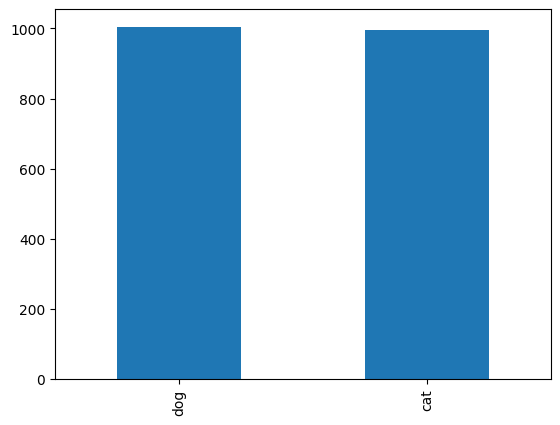

In [20]:
train_df['category'].value_counts().plot.bar()

<Axes: >

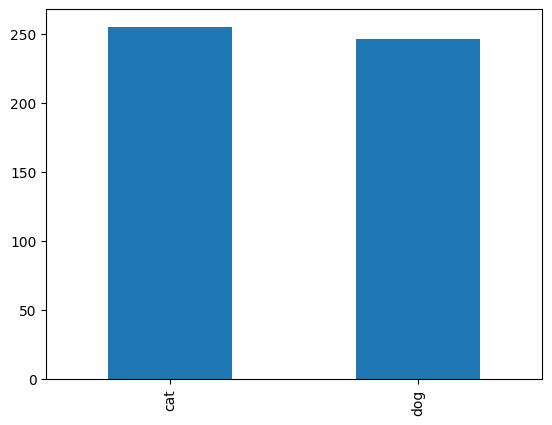

In [21]:
validate_df['category'].value_counts().plot.bar()

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### 7. Traning Generator

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/Cats_and_Dogs/train_small/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


### Validation Generator

In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/Cats_and_Dogs/train_small/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 501 validated image filenames belonging to 2 classes.


### 8. See how our generator work

In [28]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/Cats_and_Dogs/train_small/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


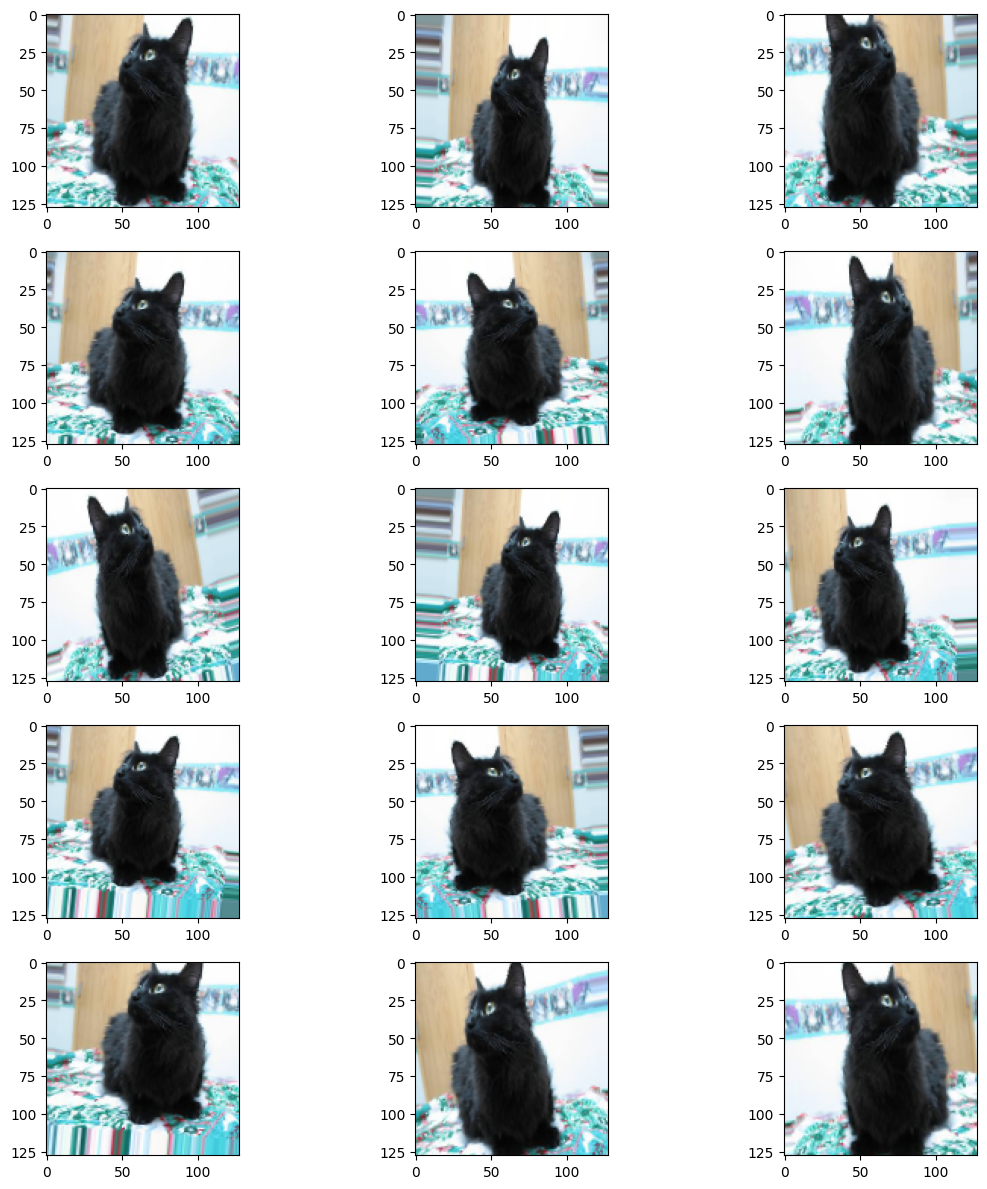

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

### 9. Fit Model

In [30]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-30-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
133/133 [==============================] - ETA: 0s - loss: 1.2535 - accuracy: 0.5491

133/133 [==============================] - 1237s 9s/step - loss: 1.2535 - accuracy: 0.5491 - val_loss: 5.8393 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 2/3
133/133 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.5758

133/133 [==============================] - 135s 1s/step - loss: 0.8986 - accuracy: 0.5758 - val_loss: 1.8764 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 3/3
133/133 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.6338

133/133 [==============================] - 135s 1s/step - loss: 0.7526 - accuracy: 0.6338 - val_loss: 0.6298 - val_accuracy: 0.6606 - lr: 0.0010


### 10. Save Model

In [31]:
model.save_weights("model.h5")

### 11. Virtualize Training

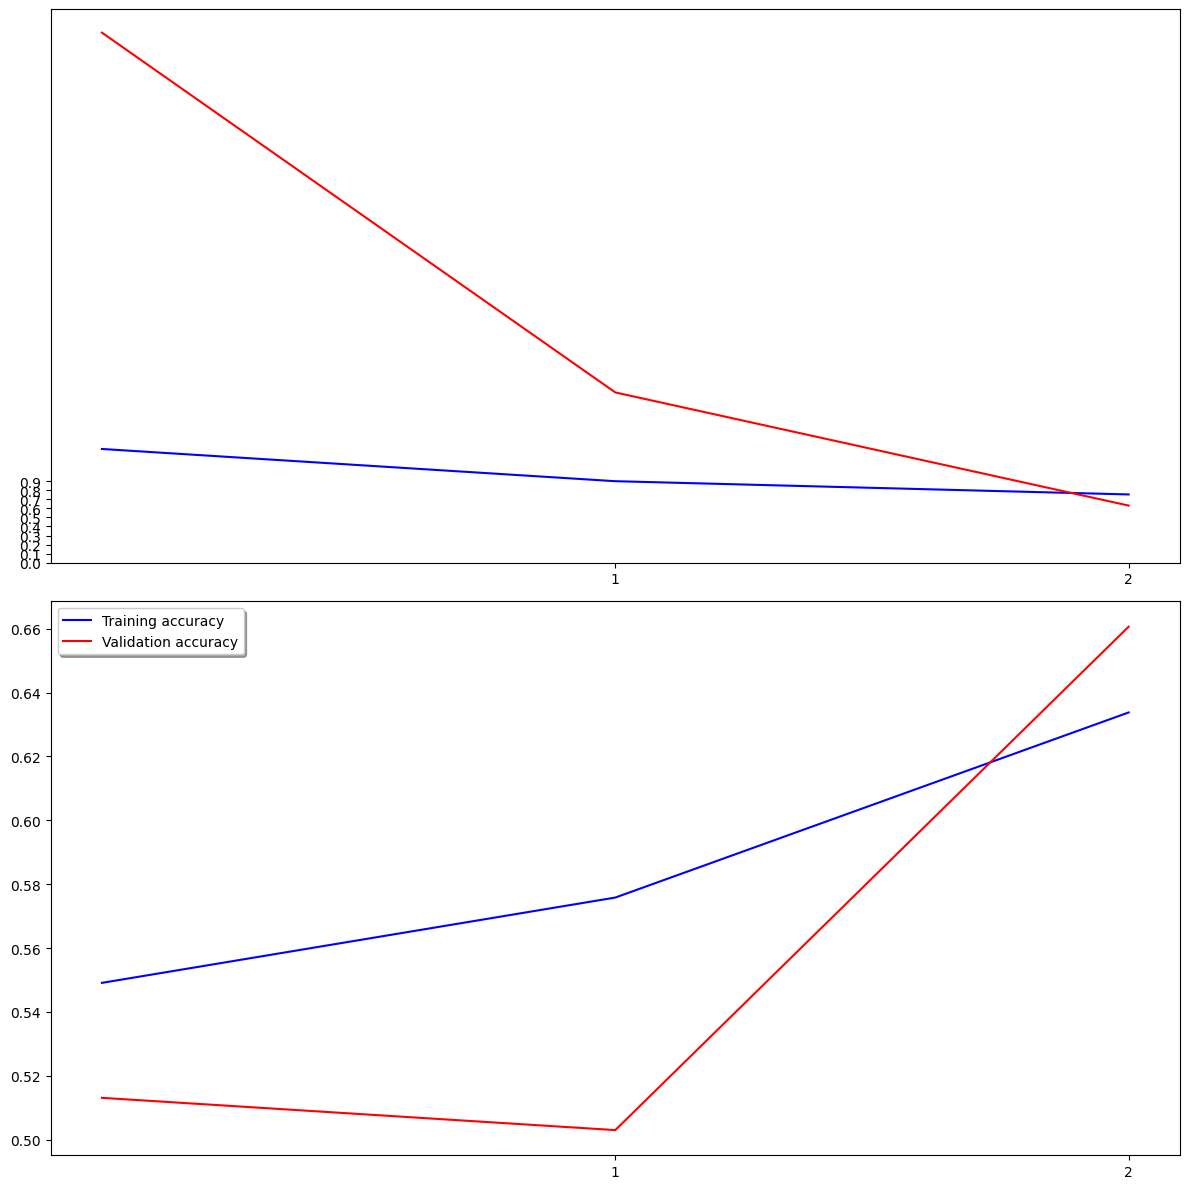

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


### 12. Prepare Testing Data

In [33]:
test_filenames = os.listdir("/content/drive/MyDrive/Cats_and_Dogs/test1_small")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### 13. Create Testing Generator

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/Cats_and_Dogs/test1_small/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1251 validated image filenames.


### 14. Predict

In [35]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-35-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [36]:
test_df['category'] = np.argmax(predict, axis=-1)

In [37]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [38]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

#### Virtualize Result

<Axes: >

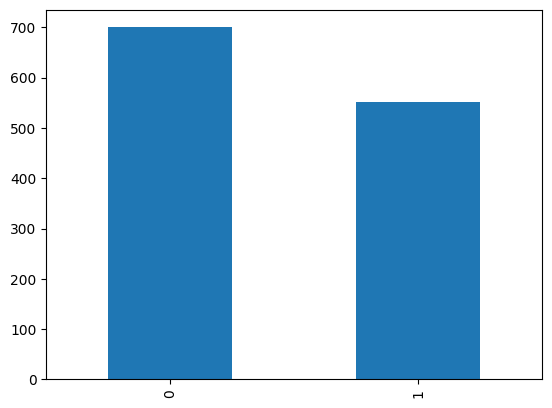

In [39]:
test_df['category'].value_counts().plot.bar()

### 15. See predicted result with images

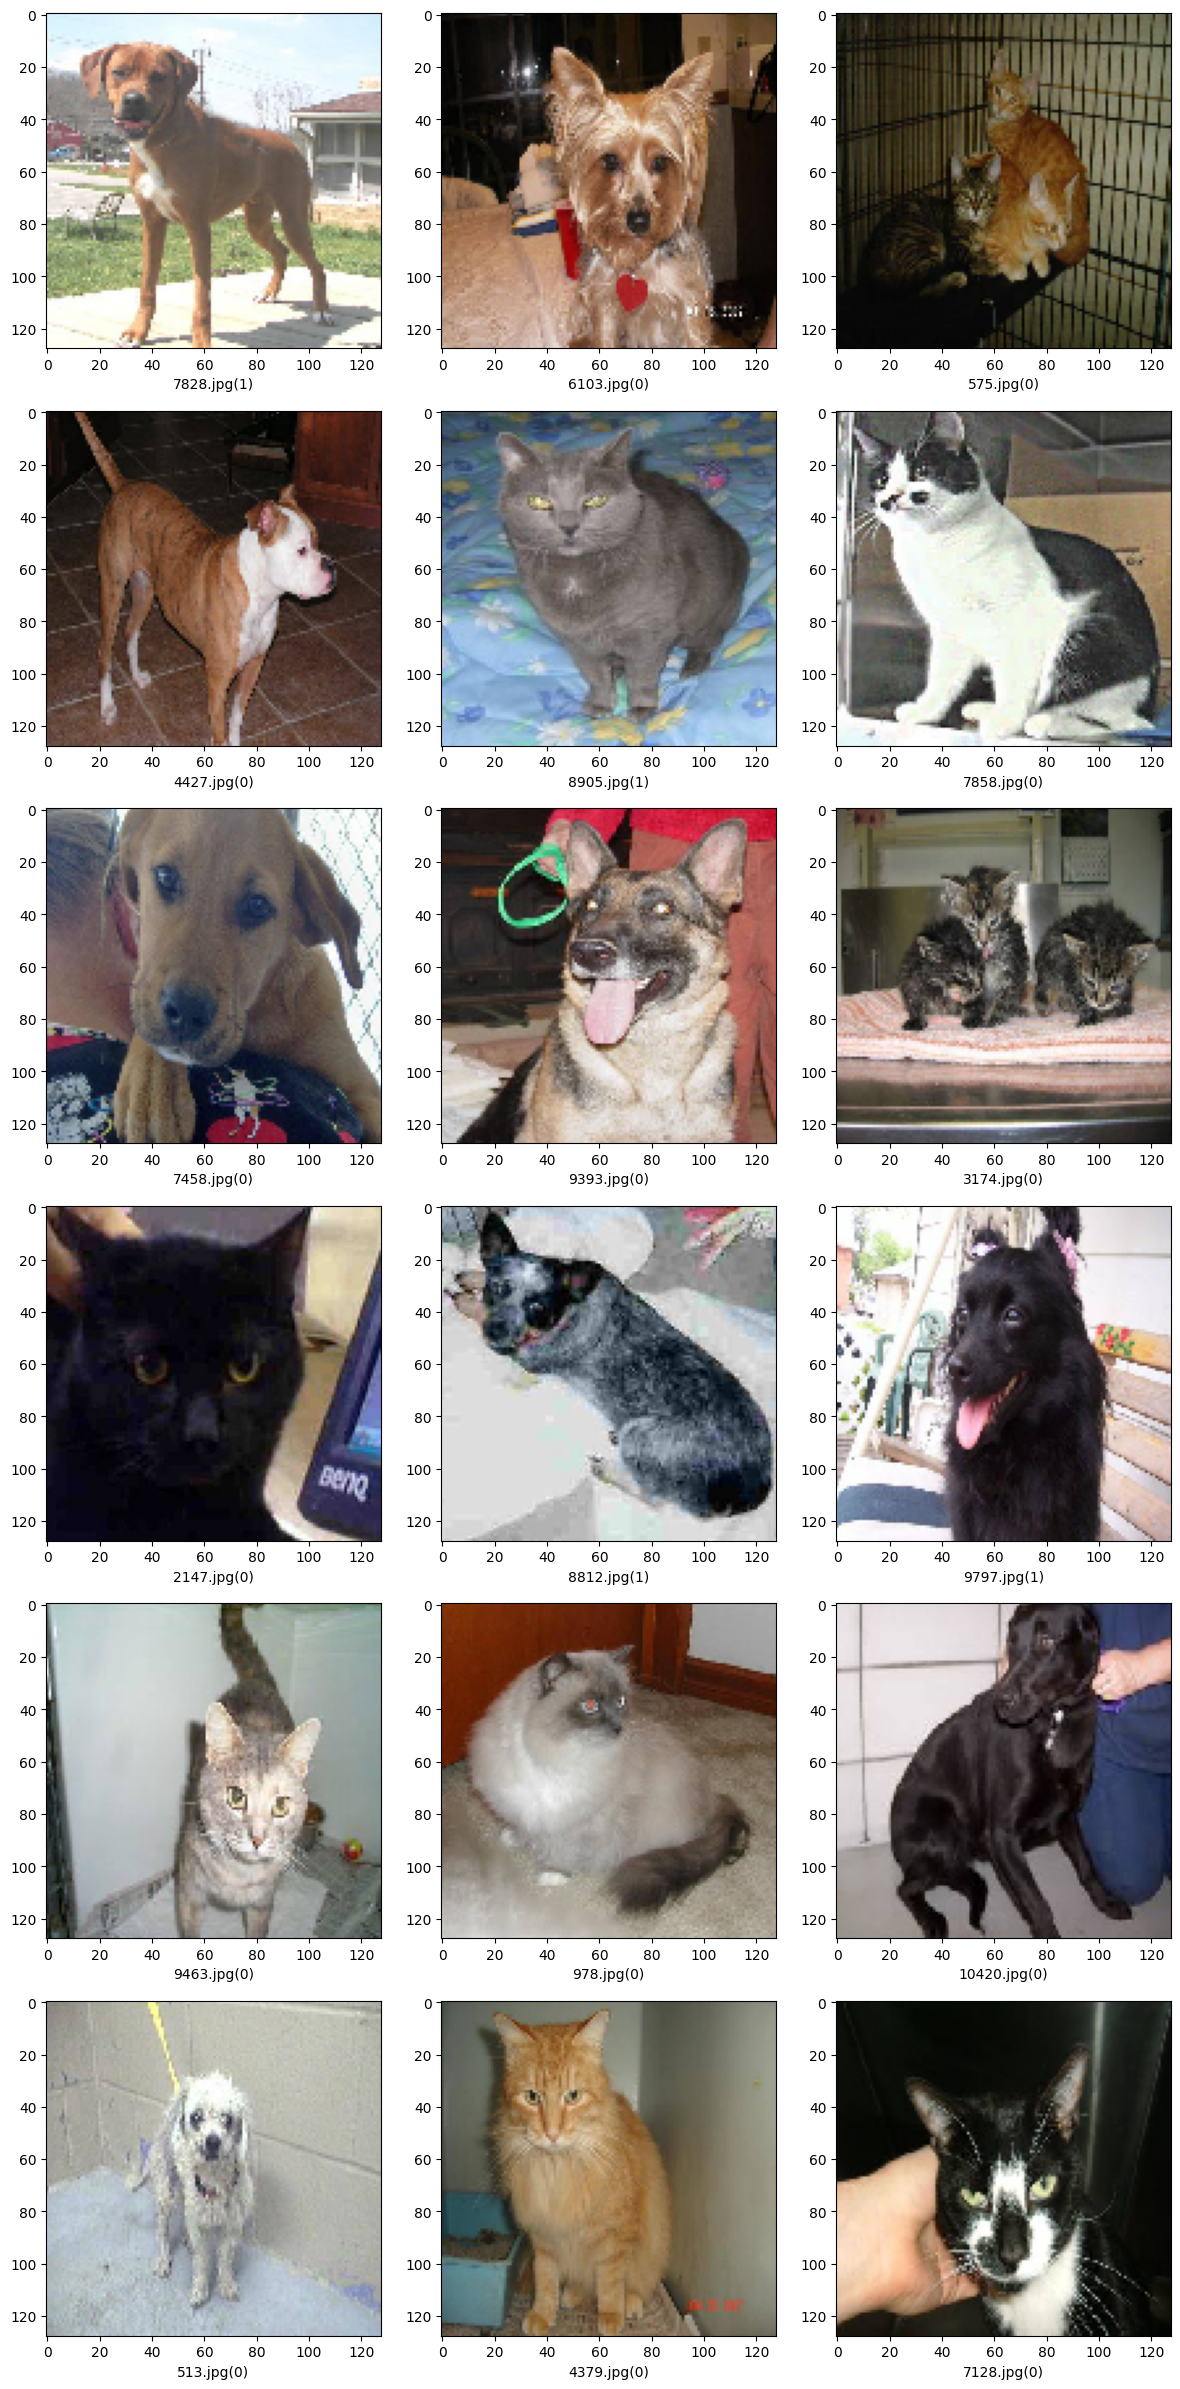

In [40]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Cats_and_Dogs/test1_small/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [41]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)